In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LassoCV,RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [2]:
# QCEW data

# 2017
df17 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2017.xlsx', 
                     sheet_name='US_St_Cn_MSA')
# 2018
df18 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2018.xlsx',
                     sheet_name='US_St_Cn_MSA')
# 2019
df19 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2019.xlsx', 
                     sheet_name='US_St_Cn_MSA')
# 2020
df20 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2020.xlsx', 
                     sheet_name='US_St_Cn_MSA')
# 2021
df21 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2021.xlsx', 
                     sheet_name='US_St_Cn_MSA')

In [3]:
# JOLTS data
j = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/jolts_2017_2021.xlsx', 
                     sheet_name='jolts')

In [4]:
# Union the QCEW annual files
df = pd.concat([df17,df18,df19,df20,df21])

In [5]:
# Get info on the columns and datatypes
print(df.info())
print(j.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314467 entries, 0 to 63008
Data columns (total 20 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Area
Code                                      314467 non-null  object 
 1   St                                             280848 non-null  object 
 2   Cnty                                           280848 non-null  float64
 3   Own                                            314467 non-null  int64  
 4   NAICS                                          314467 non-null  int64  
 5   Year                                           314467 non-null  int64  
 6   Qtr                                            314467 non-null  object 
 7   Area Type                                      314467 non-null  object 
 8   St Name                                        280758 non-null  object 
 9   Area                                  

In [6]:
# Rename columns
df.rename(columns={'Year' : 'year',
                   'Area Type': 'area_type',
                   'St Name': 'state',
                   'Ownership': 'ownership',
                   'Industry': 'industry',
                   'Annual Average Establishment Count': 'num_est',
                   'Annual Average Employment': 'num_emp',
                   'Annual Total Wages': 'total_wage',
                   'Annual Average Weekly Wage': 'weekly_wage',
                   'Annual Average Pay': 'annual_wage',
                   'Employment Location Quotient Relative to U.S.': 'elq',
                   'Total Wage Location Quotient Relative to U.S.': 'wlq'},
          inplace=True)

In [7]:
# Creating subsets that are most expressive of the desired results
df2 = df.loc[(df["area_type"] == 'State') # Other levels do not express results well
                  & (df["ownership"] == 'Private') # Other levels do not contain any industry-level data
                  & (df["industry"] != '1029 Unclassified') # Not all states contain this level, so it may inflate results
                  & (df["industry"] != '10 Total, all industries') # Removing to avoid redundancy
                  & (df["industry"] != '101 Goods-producing') # This is a parent category. Removing to avoid redundancy.
                  & (df["industry"] != '102 Service-providing') # This is a parent category. Removing to avoid redundancy.
                  & (df["Annual Average Status Code"] != 'N')] # Nothing reported for this level.


In [8]:
# Removing code from beginning of each industry level
df2['industry'] = [item[5:] for item in df2['industry']]

/var/folders/9y/lj7qm_g14lb32t9p53gc__j80000gp/T/ipykernel_71635/2678224554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['industry'] = [item[5:] for item in df2['industry']]


In [9]:
# Select columns you want to keep in the final dataset.
df2 = df2.iloc[:,[5,8,10,11,13,14,15,16,17,18,19]]

In [10]:
# Get information on latest dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538 entries, 24 to 55842
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         2538 non-null   int64  
 1   state        2538 non-null   object 
 2   ownership    2538 non-null   object 
 3   industry     2538 non-null   object 
 4   num_est      2538 non-null   int64  
 5   num_emp      2538 non-null   int64  
 6   total_wage   2538 non-null   int64  
 7   weekly_wage  2538 non-null   int64  
 8   annual_wage  2538 non-null   int64  
 9   elq          2538 non-null   float64
 10  wlq          2538 non-null   float64
dtypes: float64(2), int64(6), object(3)
memory usage: 237.9+ KB


In [11]:
# Merge the clean QCEW data and JOLTS data. 
# Take a look at the first 10 records and the table structure

df_final = pd.merge(df2,j)
print(df_final.head(10))
print(df_final.info())

   year    state ownership                              industry  num_est  \
0  2017  Alabama   Private          Natural resources and mining     1815   
1  2017  Alabama   Private                          Construction     9645   
2  2017  Alabama   Private                         Manufacturing     5447   
3  2017  Alabama   Private  Trade, transportation, and utilities    32410   
4  2017  Alabama   Private                           Information     1969   
5  2017  Alabama   Private                  Financial activities    13089   
6  2017  Alabama   Private    Professional and business services    21426   
7  2017  Alabama   Private         Education and health services    12429   
8  2017  Alabama   Private               Leisure and hospitality    10741   
9  2017  Alabama   Private                        Other services     9603   

   num_emp   total_wage  weekly_wage  annual_wage   elq   wlq  quits  \
0    17999    949424301         1014        52748  0.71  0.79    2.4   
1    852

In [ ]:
# Write to excel
df_final.to_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/Final Data/df_final.xlsx')

<AxesSubplot:>

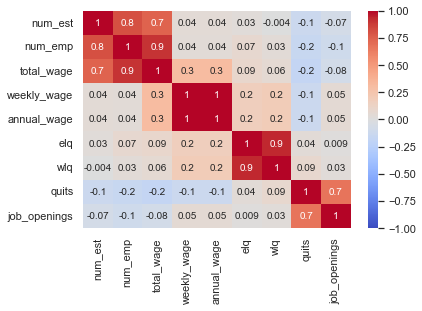

In [12]:
# Correlation plot

df_corr = df_final.iloc[:,4:]
sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(df_corr.corr(), annot = True, fmt='.1g',vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

# Linear Regression

In [13]:
# Test train split

X, y = df_final.iloc[:,[4,5,6,7,8,9,10,12]], df_final.iloc[:,11]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [15]:
# Standardization - Part of Data preprocessing

list_numerical = X.columns

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])

X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [16]:
# Fit the model

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
# Model Evaluation

pred_train_lr= lr.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_lr)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_lr),2))

print('') # Blank Space

pred_test_lr= lr.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ', round(np.sqrt(mean_squared_error(y_test,pred_test_lr)),2)) 
print('Test Data R2: ', round(r2_score(y_test, pred_test_lr),2))

Train Data RMSE:  0.34
Train Data R2:  0.51

Test Data RMSE:  0.36
Test Data R2:  0.47


# Ridge Regression

In [21]:
# Ridge with 5 fold cross-validation

model = RidgeCV(cv=5)
model.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [22]:
# Use the optimal alphas
rr = Ridge(alpha=model.alpha_)

# Fit the model
rr.fit(X_train, y_train)

# Show coefficients
print(list(zip(rr.coef_, X)))

[(-0.0068263518164935096, 'num_est'), (-0.02824178382216267, 'num_emp'), (0.003849745671599864, 'total_wage'), (-0.04353969061380039, 'weekly_wage'), (-0.05575163526059284, 'annual_wage'), (-0.11210920949408411, 'elq'), (0.15406150917702746, 'wlq'), (0.3279593495844752, 'job_openings')]


In [25]:
# Model Evaluation

pred_train_rr= rr.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_rr)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_rr),2))

print('') # Blank Space

pred_test_rr= rr.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ', round(np.sqrt(mean_squared_error(y_test,pred_test_rr)),2)) 
print('Test Data R2: ', round(r2_score(y_test, pred_test_rr),2))

Train Data RMSE:  0.34
Train Data R2:  0.51

Test Data RMSE:  0.36
Test Data R2:  0.47


# Lasso Regression

In [28]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [29]:
# Use the optimal alpha
lasso = Lasso(alpha=model.alpha_)

# Fit the model
lasso.fit(X_train, y_train)

# Show coefficients
print(list(zip(lasso.coef_, X)))

[(-0.006302517066680019, 'num_est'), (-0.02506064492635176, 'num_emp'), (-0.0, 'total_wage'), (-0.09704081860107784, 'weekly_wage'), (-0.0004377221041248233, 'annual_wage'), (-0.1041377378383156, 'elq'), (0.14586724013437782, 'wlq'), (0.32774825228527166, 'job_openings')]


In [30]:
# Model Evaluation

pred_train_lasso= lasso.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_lasso)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_lasso),2))

print('') # Blank Space

pred_test_lasso= lasso.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ', round(np.sqrt(mean_squared_error(y_test,pred_test_lasso)),2)) 
print('Test Data R2: ', round(r2_score(y_test, pred_test_lasso),2))

Train Data RMSE:  0.34
Train Data R2:  0.51

Test Data RMSE:  0.36
Test Data R2:  0.47


# Random Forest

In [31]:
# Fit Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

In [32]:
# Model Evaluation

pred_train_rf= rf.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_rf)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_rf),2))

print('') # Blank Space

pred_test_rf= rf.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ',round(np.sqrt(mean_squared_error(y_test,pred_test_rf)),2))
print('Test Data R2: ',round(r2_score(y_test, pred_test_rf),2))

Train Data RMSE:  0.1
Train Data R2:  0.96

Test Data RMSE:  0.28
Test Data R2:  0.68


In [33]:
# Feature Importance 

def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

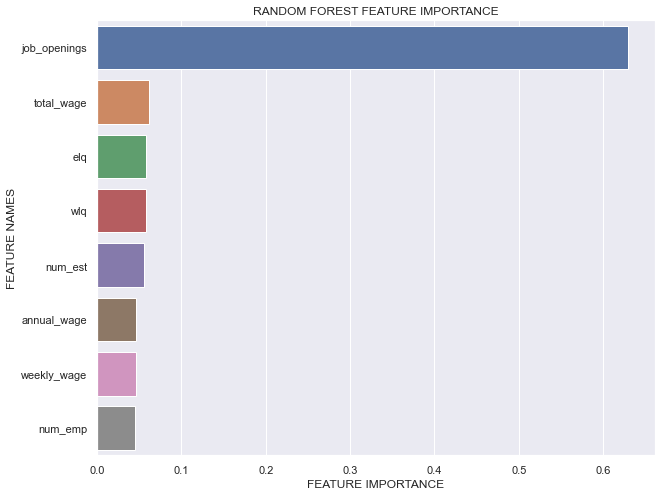

In [34]:
# Feature Importance Plot

plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST ')